# Trabalho Final do Curso de Ciências de Dados e Big Data da PUC Minas

**Importando as biliotecas** 

In [ ]:
!pip install vaderSentiment

In [ ]:
from ast import keyword
from distutils.command.clean import clean
from itertools import count
from datetime import datetime
from xml.etree.ElementInclude import include
from textblob import TextBlob
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import tweepy
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

**Definindo a classe para tratamento das informações do Tweeter**

In [ ]:
class TweetSearch():
  def __init__(self,  filepath) -> None:
    '''
    Get twittes on file put into dataframe
    '''
    
    self.filepath = filepath
    self.vaderAnalyzer = SentimentIntensityAnalyzer()

  def __clean(self, text):
    '''
    Cleaning a text
    '''
    clean_text = re.sub(r'RT+', '', text)
    clean_text = re.sub(r'@\S+', '', clean_text)
    clean_text = re.sub(r'https?\S+', '', clean_text)
    clean_text = clean_text.replace('\n',' ')
    clean_text = clean_text.replace('Em resposta','')
    clean_text = clean_text.replace('Mostrar esta','')

    return clean_text

  def __clean_retweets(self, text):
    '''
    Cleaning a text
    '''
    if (type(text) == str):
      clean_text = re.sub(r"[a-z]", '', text)
      clean_text = re.sub(r',', '.', clean_text)
    else:
      clean_text = str(text)

    return clean_text

  def clean_tweet(self, tweets_df):
    '''
    Tweets cleaning
    '''
    tweets_data_list = []
    tweets_df = tweets_df.reset_index()
    
    for item in tweets_df.itertuples(index=False):
      tweet_text = self.__clean(item.Embedded_text)
      retweet_text = self.__clean_retweets(item.Retweets)
      tweets_data = {
            'TweetText' : tweet_text,
            'Retweets' : retweet_text
        }
      tweets_data_list.append(tweets_data)
    
    return tweets_data_list

  def prepare_tweets_list(self):
    '''
    Transforming the data to DataFrame
    '''
    tweets_founded = pd.read_csv(self.filepath, header=0, dtype={'UserScreenName': 'str', 'UserName': 'str', 'Timestamp': 'str', 
                                                      'Text': 'str', 'Embedded_text': 'str', 'Emojis' : 'str', 
                                                      'Comments': 'str', 'Likes': 'str', 'Retweets': 'str', 'Imagelink': 'str',  
                                                      'Tweet URL': 'str'})
    new_df = tweets_founded[['UserScreenName', 'UserName', 'Timestamp', 'Text', 'Embedded_text', 'Likes', 'Retweets']]
    new_df = new_df.copy()
    new_df.fillna(0, inplace=True)
    new_df['Date'] = pd.to_datetime(tweets_founded['Timestamp'], errors='coerce')
    new_df['Date'] = new_df['Date'].dt.strftime('%Y-%m-%d')
   
    return new_df

  def sentiment_polarity(self, tweets_text_list):
    '''
    Sentimental polarity
    '''
    tweets_sentiments_list = []
    sentiment_text = ''

    for tweet in tweets_text_list:
        polarity = TextBlob(tweet).sentiment.polarity
        
        if polarity > 0:
            sentiment_text = 'Positive'
        elif polarity < 0:
            sentiment_text = 'Negative'
        else:
            sentiment_text = 'Neutral'
        tweets_sentiment = {
            'Sentiment_Value':polarity,
            'Sentiment_Text' :sentiment_text
        }
        tweets_sentiments_list.append(tweets_sentiment)
    
    return tweets_sentiments_list

  def sentiment_polarity_from_vader(self, tweets_text_list):
    '''
    Sentimental analyse
    '''
    tweets_sentiments_list = []
    sentiment_text = ''

    for tweet in tweets_text_list:
        polarity = self.vaderAnalyzer.polarity_scores(tweet)
        
        if polarity['compound'] >= 0.05:
            sentiment_text = 'Positive'
        elif polarity['compound'] <= -0.05:
            sentiment_text = 'Negative'
        else:
            sentiment_text = 'Neutral'
        tweets_sentiment = {
            'Sentiment_Compound':polarity['compound'],
            'Sentiment_Neutral':polarity['neu'],
            'Sentiment_Negative':polarity['neg'],
            'Sentiment_Positive':polarity['pos'],
            'Sentiment_Text' :sentiment_text
        }
        tweets_sentiments_list.append(tweets_sentiment)
    
    return tweets_sentiments_list


**Processamento do arquivo de tweets / analise VADER**

In [ ]:
analyzer = TweetSearch('tweets_btc_2021-01-01_to_2021-12-31.csv')
#transformando em Dataframe
tweets_df = analyzer.prepare_tweets_list()
#realizando a limpeza dos tweets
tweets_cleaned = analyzer.clean_tweet(tweets_df)
tweets_cleaned_df = pd.DataFrame(tweets_cleaned)
tweets_df['TweetTextClean'] = tweets_cleaned_df['TweetText']
#realizando a analise de sentimentos com VADER
tweets_sentiment = analyzer.sentiment_polarity_from_vader(tweets_df['TweetTextClean'])
tweets_sentiment = pd.DataFrame(tweets_sentiment)

In [ ]:
#data analyser
#criando as novas colunas on DataFrame
tweets_df[['Sentiment_Compound', 'Sentiment_Neutral', 'Sentiment_Negative', 'Sentiment_Positive', 'Sentiment_Text']] = 
tweets_sentiment[['Sentiment_Compound', 'Sentiment_Neutral', 'Sentiment_Negative', 'Sentiment_Positive', 'Sentiment_Text']]
#gerando um novo dataframe somente com as informações necessarias nas próximas etapas
tweets_filter = tweets_df[['Date', 'TweetTextClean', 'Sentiment_Compound', 'Sentiment_Neutral', 'Sentiment_Negative', 'Sentiment_Positive', 'Sentiment_Text']]
#vizualizando a ultima linha do dataset
tweets_filter.iloc[-1]



Date                                                         2021-12-31
TweetTextClean         a      e   Lol. Wtf u talking about?    has a...
Sentiment_Compound                                                -0.25
Sentiment_Neutral                                                 0.663
Sentiment_Negative                                                0.194
Sentiment_Positive                                                0.143
Sentiment_Text                                                 Negative
Name: 362707, dtype: object

In [ ]:
# Testando proximo passo
from datetime import date, timedelta 
d = date(2021, 10, 18)
sum_pos = tweets_filter[(tweets_filter.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Positive']
sum_neg = tweets_filter[(tweets_filter.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Negative']
sum_neu = tweets_filter[(tweets_filter.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Neutral']
sum_comp = tweets_filter[(tweets_filter.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Compound']
print(f'Data: {d.strftime("%Y-%m-%d")} Soma_Pos:{sum_pos} Soma_Neg:{sum_neg} Soma_neu:{sum_neu} Soma_comp:{sum_comp}')



Data: 2021-10-18 Soma_Pos:89.396 Soma_Neg:36.330999999999996 Soma_neu:874.267 Soma_comp:178.0969


# Agrupando os dados por dia

In [ ]:
from datetime import date, timedelta 
import time

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def groupTweetsByDay(tweets):
  # Grouping tweets by day
  start_date = date(2021, 1, 1)
  end_date = date(2022, 1, 1)
  dtypes = np.dtype([('date', str),('neu_mean', float), ('neg_mean', float), ('pos_mean', float), ('comp_mean', float), ('pol_mean', float), ('qtd_day', int)])
  new_df = pd.DataFrame(np.empty(0, dtype=dtypes))

  for d in daterange(start_date, end_date):
    sum_neu = tweets[(tweets.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Neutral']
    sum_neg = tweets[(tweets.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Negative']
    sum_pos = tweets[(tweets.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Positive']
    sum_comp = tweets[(tweets.Date==d.strftime("%Y-%m-%d"))].sum()['Sentiment_Compound']
    total_tweets_of_day = tweets[(tweets.Date==d.strftime("%Y-%m-%d"))].count()['Date']
    new_row = {
         'date': d.strftime("%Y-%m-%d"), 
         'neu_mean': sum_neu/total_tweets_of_day, 
         'neg_mean': sum_neg/total_tweets_of_day, 
         'pos_mean': sum_pos/total_tweets_of_day, 
         'comp_mean': sum_comp/total_tweets_of_day, 
         'pol_mean': math.sqrt(sum_pos/total_tweets_of_day * sum_neg/total_tweets_of_day),
         'qtd_day': total_tweets_of_day
         }
    new_df = new_df.append(new_row, ignore_index=True)
    
  return new_df


In [ ]:
#grouping data per day
new_df = groupTweetsByDay(tweets_filter)
new_df


,date,neu_mean,neg_mean,pos_mean,comp_mean,pol_mean,qtd_day
0,2021-01-01,0.854263,0.045843,0.099883,0.182852,0.067668,1000
1,2021-01-02,0.865478,0.044039,0.090482,0.155658,0.063125,1000
2,2021-01-03,0.862065,0.041362,0.096569,0.169264,0.063200,1000
3,2021-01-04,0.864370,0.040225,0.095397,0.202557,0.061946,1000
4,2021-01-05,0.864378,0.036116,0.099508,0.216036,0.059949,1000
...,...,...,...,...,...,...,...
360,2021-12-27,0.859985,0.046149,0.093852,0.150913,0.065812,1000
361,2021-12-28,0.855977,0.051500,0.092514,0.145640,0.069025,1000
362,2021-12-29,0.858153,0.056188,0.085661,0.115104,0.069377,1000
363,2021-12-30,0.853271,0.047745,0.098975,0.172850,0.068743,1000


# Adicionando os dados da variação dos bitcoins

In [ ]:
import requests
import time
import datetime

class BitcoinRequest:
    def __init__(self, api_key):
        self.api_key = api_key
        self.BASE_URL = 'https://min-api.cryptocompare.com/data/v2'

    def __get_data(self, response):
        return response.json()['Data']['Data']

    def get_dialy_data(self, fsym='BTC', tsym='USD', aggregate=1, limit=365):
      '''
      Get values of bitcoin market
      '''
      response = requests.get(f'{self.BASE_URL}/histoday?fsym={fsym}&tsym={tsym}&aggregate={aggregate}&limit={limit}&api_key={self.api_key}')
      return self.__get_data(response)
    
    def diff_dates(self, date1, date2):
      return abs(date2-date1).days

    def get_index(self, listBT, timestamp):
      '''
      Get a index of bitcoin date
      '''      
      for index in range(len(listBT)):
        if (listBT[index]['time'] == timestamp):
          return index
    
    def get_target_function(self, current_closing, next_closing):
        '''
        Get Z(t) for the hour starting at {time}.
        Z(t) is defined as follows:
            - If there is an increment in the closing price between t and t+1, Z(t) = 1
            - else, Z(t) = -1
        '''
        return 1 if next_closing >= current_closing else -1

In [ ]:
apy_key = "582a4eea85fa4058d78c6994e9f7af704768d5d5eb93e10dee801962c3695823"

bitcoinRequest = BitcoinRequest(api_key=apy_key)
data_inicial = datetime.datetime(2020, 12, 31)
data_final = datetime.datetime.now()
days = abs(data_inicial-data_final).days
jsonData = bitcoinRequest.get_dialy_data(fsym='BTC', tsym='USD', aggregate=1, limit=days)

# add informations about bitcoin
bt_close = []
bt_open = []
bt_high = []
bt_low = []
bt_volumeto = []
bt_target = []
for item in new_df.itertuples(index=False):
  timestamp = time.mktime(datetime.datetime.strptime(item.date, "%Y-%m-%d").timetuple())
  index = bitcoinRequest.get_index(jsonData, timestamp)
  if index != None:
    bt_close.append(jsonData[index-1]['close'])
    bt_open.append(jsonData[index]['open'])
    bt_high.append(jsonData[index]['high'])
    bt_low.append(jsonData[index]['low'])
    bt_volumeto.append(jsonData[index]['volumeto'])
    bt_target.append(bitcoinRequest.get_target_function(jsonData[index-1]['close'], jsonData[index]['close']))
    
new_df['bt_close'] = bt_close
new_df['bt_open'] = bt_open
new_df['bt_high'] = bt_high
new_df['bt_low'] = bt_low
new_df['bt_volumeto'] = bt_volumeto
new_df['bt_target'] = bt_target


In [ ]:
new_df

,date,neu_mean,neg_mean,pos_mean,comp_mean,pol_mean,qtd_day,bt_close,bt_open,bt_high,bt_low,bt_volumeto,bt_target
0,2021-01-01,0.854263,0.045843,0.099883,0.182852,0.067668,1000,28972.40,28972.40,29666.33,28748.21,1.487306e+09,1
1,2021-01-02,0.865478,0.044039,0.090482,0.155658,0.063125,1000,29388.94,29388.94,33257.29,29036.26,3.750441e+09,1
2,2021-01-03,0.862065,0.041362,0.096569,0.169264,0.063200,1000,32203.64,32203.64,34789.34,32010.59,3.132759e+09,1
3,2021-01-04,0.864370,0.040225,0.095397,0.202557,0.061946,1000,33063.48,33063.48,33622.70,28493.29,3.901979e+09,-1
4,2021-01-05,0.864378,0.036116,0.099508,0.216036,0.059949,1000,32030.55,32030.55,34487.44,29985.29,3.037657e+09,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2021-12-27,0.859985,0.046149,0.093852,0.150913,0.065812,1000,50790.88,50790.88,52079.46,50481.26,1.120188e+09,-1
361,2021-12-28,0.855977,0.051500,0.092514,0.145640,0.069025,1000,50714.73,50714.73,50718.53,47317.78,1.985905e+09,-1
362,2021-12-29,0.858153,0.056188,0.085661,0.115104,0.069377,1000,47536.39,47536.39,48145.34,46107.79,1.599557e+09,-1
363,2021-12-30,0.853271,0.047745,0.098975,0.172850,0.068743,1000,46471.70,46471.70,47917.89,45964.28,1.852207e+09,1


In [ ]:
new_df.to_csv("matriz_resultado_rede_neural.csv", index=False)

# Análises
**Qual o tweet mais curtido e retweetado?**

In [ ]:
likes_max = np.max(pd.to_numeric(tweets_df['Likes']))
tweet_text = tweets_df[pd.to_numeric(tweets_df['Likes']) == likes_max].TweetTextClean.item()
tweet_sentiment = tweets_df[pd.to_numeric(tweets_df['Likes']) == likes_max].Sentiment_Text.item()

print(f"O tweet com mais curtidas é: {tweet_text}")
print(f"Este tweet foi classificado como: {tweet_sentiment}")
print(f"Numero de curtidas: {likes_max}")

O tweet com mais curtidas é: "#bitcoin is not volatile to an investor with a 4 year time frame"  123 950 5.434
Este tweet foi classificado como: Neutral
Numero de curtidas: 950.0


In [ ]:
retweet_max = np.max(pd.to_numeric(tweets_df.Retweets))
retweet_text = tweets_df[pd.to_numeric(tweets_df.Retweets) == retweet_max].TweetTextClean.item()
retweet_sentiment = tweets_df[pd.to_numeric(tweets_df.Retweets) == retweet_max].Sentiment_Text.item()

print(f"O tweet com mais retweets é: {retweet_text}")
print(f"Este tweet foi classificado como: {retweet_sentiment}")
print(f"Numero de curtidas: {retweet_max}")

O tweet com mais retweets é: Bitcoin is going up and down 1000 dollars in 5 minutes LMAO 42 32 998
Este tweet foi classificado como: Positive
Numero de curtidas: 998.0


# Qual a porcentagem dos sentimentos captados?

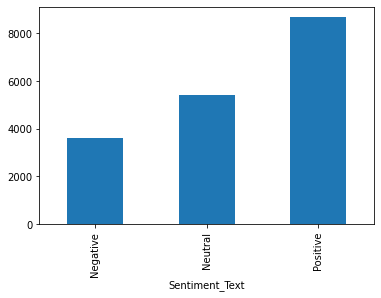

<Figure size 432x288 with 0 Axes>

In [ ]:
# Print result
sentiment_percentage = tweets_df.groupby('Sentiment_Text')['UserName'].count().apply(lambda x:100*x/500)
sentiment_percentage.plot(kind='bar')
plt.show()
plt.savefig('sentiments_tweets.png', bbox_inches='tight', pad_inches=0.5)

# Quais as palavras mais atribuídas?

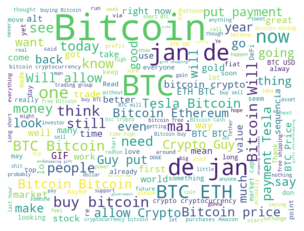

In [ ]:
words = ' '.join(tweets_df['TweetTextClean'])

words_clean = " ".join([word for word in words.split()])

warnings.simplefilter('ignore')

wc = WordCloud(stopwords=STOPWORDS,
               max_words=1000, max_font_size=100,
               min_font_size=10, random_state=42,
               background_color='white', mode="RGB",
               width=800, height=600,
               normalize_plurals=True).generate(words_clean)

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('bitcoin_cloud.png', dpi=300)
plt.show()

#Treinamento rede neural

Len V Test: 110
Len Z Test: 110
Len V: 255
Len Z: 255
####### Best MLP Results #######
MLP Accuracy Score: 0.8363636363636363

MLP Precision Score: 0.8225806451612904

MLP Recall Score: 0.8793103448275862

MLP F1 Score: 0.8500000000000001




####### Random Forest Results #######
Random Forest Accuracy Score: 0.5909090909090909

Random Forest Precision Score: 0.6140350877192983

Random Forest Recall Score: 0.603448275862069

Random Forest F1 Score: 0.608695652173913




####### SVM Results #######
SVM Accuracy Score: 0.5818181818181818

SVM Precision Score: 0.5833333333333334

SVM Recall Score: 0.7241379310344828

SVM F1 Score: 0.6461538461538462




####### Cross Validation MLP #######
Cross Validation Precision: 0.5123123123123123
Cross Validation Accuracy: 0.5123123123123123
Cross Validation Recall: 1.0
Cross Validation F1: 0.6774675324675326



####### Confusion Matrix MLP #######


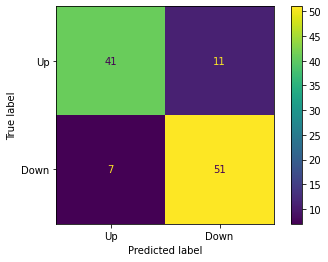

In [ ]:
import pandas as pd
import datetime
import random
import time
import numpy as np
import collections
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def neural_train(data, target):
  V, V_test, Z, Z_test = train_test_split(data, target, test_size=0.3, random_state = 1)
  
  scaler = preprocessing.StandardScaler()
  #Fit only over test data
  scaler.fit(V)
  V = scaler.transform(V)
  V_test = scaler.transform(V_test)

  random.seed = time.time()
  max_acc = -1
  best_mlp = None
  max_pre = -1

  for i in range(50):
    # mlp = MLPClassifier(solver='adam', alpha=0.0002, learning_rate_init=0.00001, max_iter=500, early_stopping=True, hidden_layer_sizes=(55, ), activation='tanh', random_state=1)
    mlp = MLPClassifier(solver='lbfgs', alpha=0.0002, learning_rate_init=0.00001, max_iter=500, early_stopping=True, hidden_layer_sizes=(30, ), activation='tanh', random_state=1)
    # mlp = MLPClassifier(solver='sgd', alpha=0.0002, learning_rate_init=0.00001, max_iter=500, early_stopping=True, hidden_layer_sizes=(55, ), activation='tanh', random_state=1)

    mlp.fit(V, Z)

    Z_predict = mlp.predict(V_test)

    acc = accuracy_score(Z_test, Z_predict)
#    print(f"Accuracy Score: {acc}")

    pre = precision_score(Z_test, Z_predict)
#    print(f"Precision Score: {pre}")

#    print("Confusion Matrix:")
#    print(confusion_matrix(Z_test, Z_predict))

    if acc > max_acc:
      max_acc = acc
      best_mlp = mlp
    
    if pre > max_pre:
      max_pre = pre


  #print(f"Max acc: {max_acc}")
  #print(f"Max pre: {max_pre}")
  #Print result analise
  print(f"Len V Test: {len(V_test)}")
  print(f"Len Z Test: {len(Z_test)}")
  print(f"Len V: {len(V)}")
  print(f"Len Z: {len(Z)}")

  print("####### Best MLP Results #######")
  Z_predict = best_mlp.predict(V_test)
  accuracy = accuracy_score(Z_test, Z_predict)
  print(f"MLP Accuracy Score: {accuracy_score(Z_test, Z_predict)}\n")
  precision = precision_score(Z_test, Z_predict)
  print(f"MLP Precision Score: {precision}\n")
  recall = recall_score(Z_test, Z_predict)
  print(f"MLP Recall Score: {recall}\n")
  f1 = f1_score(Z_test, Z_predict)
  print(f"MLP F1 Score: {f1}\n")
  cm = confusion_matrix(Z_test, Z_predict)
  print('\n\n')

  # Random Forest
  rf = RandomForestClassifier(n_estimators=1000)
  rf.fit(V,Z)

  Z_predict = rf.predict(V_test)
  acc = accuracy_score(Z_test, Z_predict)
  print("####### Random Forest Results #######")
  print(f"Random Forest Accuracy Score: {accuracy_score(Z_test, Z_predict)}\n")
  precision = precision_score(Z_test, Z_predict)
  print(f"Random Forest Precision Score: {precision}\n")
  recall = recall_score(Z_test, Z_predict)
  print(f"Random Forest Recall Score: {recall}\n")
  f1 = f1_score(Z_test, Z_predict)
  print(f"Random Forest F1 Score: {f1}\n")
  print('\n\n')

  # SVM
  svm = SVC(kernel='rbf')
  svm.fit(V,Z)
  
  Z_predict = svm.predict(V_test)
  acc = accuracy_score(Z_test, Z_predict)
  print("####### SVM Results #######")
  print(f"SVM Accuracy Score: {accuracy_score(Z_test, Z_predict)}\n")
  precision = precision_score(Z_test, Z_predict)
  print(f"SVM Precision Score: {precision}\n")
  recall = recall_score(Z_test, Z_predict)
  print(f"SVM Recall Score: {recall}\n")
  f1 = f1_score(Z_test, Z_predict)
  print(f"SVM F1 Score: {f1}\n")
  print('\n\n')


  print("####### Cross Validation MLP #######")
  cv = 10
  scores_precision = cross_val_score(best_mlp, data, target, cv=cv, scoring='precision')
  print(f'Cross Validation Precision: {scores_precision.mean()}')
  scores_accuracy = cross_val_score(best_mlp, data, target, cv=cv, scoring='accuracy')
  print(f'Cross Validation Accuracy: {scores_accuracy.mean()}')
  scores_recall = cross_val_score(best_mlp, data, target, cv=cv, scoring='recall')
  print(f'Cross Validation Recall: {scores_recall.mean()}')
  scores_f1 = cross_val_score(best_mlp, data, target, cv=cv, scoring='f1')
  print(f'Cross Validation F1: {scores_f1.mean()}')
  print('\n\n')

  print("####### Confusion Matrix MLP #######")
  cmd = ConfusionMatrixDisplay(cm, display_labels=['Up','Down'])
  cmd.plot()
  

df_train_matrix = pd.read_csv('matriz_resultado_rede_neural.csv', header=0, dtype={'date': 'str', 'neu_mean': 'float', 'neg_mean': 'float', 
                                                      'pos_mean': 'float', 'comp_mean': 'float', 'pol_mean' : 'float', 
                                                      'bt_close': 'float', 'bt_open': 'float', 'bt_high': 'float', 'bt_low': 'float',  
                                                      'bt_volumeto': 'float', 'bt_target': 'float'})
target = df_train_matrix['bt_target']
# mixed data (market and tweets)
data = df_train_matrix[['neu_mean', 'neg_mean', 'pos_mean', 'comp_mean', 'pol_mean','bt_close', 'bt_open', 'bt_high', 'bt_low', 'bt_volumeto']]
# market data
# data = df_train_matrix[['bt_close', 'bt_open', 'bt_high', 'bt_low', 'bt_volumeto']]
# tweets data
# data = df_train_matrix[['neu_mean', 'neg_mean', 'pos_mean', 'comp_mean', 'pol_mean']]
neural_train(data, target)


In [ ]:
data = df_train_matrix[['bt_close', 'bt_open', 'bt_high', 'bt_low', 'bt_volumeto', 'bt_target']]
# data = df_train_matrix[['neu_mean', 'neg_mean', 'pos_mean', 'comp_mean', 'pol_mean', 'bt_target']]
print(data)

     bt_close   bt_open   bt_high    bt_low   bt_volumeto  bt_target
0    28972.40  28972.40  29666.33  28748.21  1.487306e+09        1.0
1    29388.94  29388.94  33257.29  29036.26  3.750441e+09        1.0
2    32203.64  32203.64  34789.34  32010.59  3.132759e+09        1.0
3    33063.48  33063.48  33622.70  28493.29  3.901979e+09       -1.0
4    32030.55  32030.55  34487.44  29985.29  3.037657e+09        1.0
..        ...       ...       ...       ...           ...        ...
359  50431.63  50431.63  51283.70  49485.62  7.366178e+08        1.0
360  50790.88  50790.88  52079.46  50481.26  1.120188e+09       -1.0
361  50714.73  50714.73  50718.53  47317.78  1.985905e+09       -1.0
362  47536.39  47536.39  48145.34  46107.79  1.599557e+09       -1.0
363  46471.70  46471.70  47917.89  45964.28  1.852207e+09        1.0

[364 rows x 6 columns]
